In [2]:
%matplotlib inline

import calendar
from calendar import isleap
import datetime
import os

import numpy as np
from scipy.stats import gaussian_kde

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import xarray as xr
from netCDF4 import Dataset

import pandas as pd
from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from eofs.standard import Eof

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [3]:
dir_data='./data/'
dir_res='./result/'
dir_figs='./figs/'
dir_anim='./anim/'

if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

# Etape 1 : ouverture et traitement des données quotidiennes

In [4]:
infile = dir_data+'era5_z500_natl_daily_1950-2020_1deg5.nc'
varname='z'
var_div=9.81
units='m'

data = xr.open_dataset(infile)

In [5]:
var_text = 'z500'
season = 'winter'
season_name = 'winter'
domain_name = 'natl'
domain='North Atlantic'
latS=20
latN=80
lonW=-80
lonE=30

startday  = '1960-12-01T18'
endday  = '2020-03-31T18'

# Date index from startday to endday
dates = pd.date_range(startday, endday, freq='D')

# Select Season
months=np.any([dates.month==12,dates.month==1,dates.month==2,dates.month==3],axis=0)

dates2=dates[months]

In [6]:
data_season = data.sel(lat=slice(latS,latN)).sel(lon=slice(lonW,lonE)).sel(time=dates2)

lat  = data_season.lat.values
lon  = data_season.lon.values
time  = data_season.time.values

season1= str(data_season.time.values[130])[0:4]
season2= str(data_season.time.values[-1])[0:4]


print(' ----- Saving new seasonnal file from '+startday+ ' to '+endday+ ' on new domain  ----- ')
infile1 = dir_res+varname+'_'+startday+'_'+endday+'_'+domain_name+'.nc'
data_season.to_netcdf(infile1)
print(' new daily seasonnal file over subdomain is here : ')
print(infile1)

 ----- Saving new seasonnal file from 1960-12-01T18 to 2020-03-31T18 on new domain  ----- 
 new daily seasonnal file over subdomain is here : 
./result/z_1960-12-01T18_2020-03-31T18_natl.nc


In [7]:
print(' ----- Computing daily anomalies ----- ')
data_anom = data_season.groupby('time.dayofyear') - data_season.groupby('time.dayofyear').mean('time')
print(data_anom)
print(' ----- Writing netcdf ----- ')
infile2 = dir_res+varname+'_anom_'+startday+'_'+endday+'_'+domain_name+'.nc'
data_anom.to_netcdf(infile2)
print(' netcdf file of daily anomalies is here : ')
print(infile2)

 ----- Computing daily anomalies ----- 
<xarray.Dataset>
Dimensions:    (time: 7275, lon: 74, lat: 40)
Coordinates:
  * time       (time) datetime64[ns] 1960-12-01T18:00:00 ... 2020-03-31T18:00:00
  * lon        (lon) float64 -79.5 -78.0 -76.5 -75.0 ... 25.5 27.0 28.5 30.0
  * lat        (lat) float64 21.0 22.5 24.0 25.5 27.0 ... 75.0 76.5 78.0 79.5
    dayofyear  (time) int64 336 337 338 339 340 341 342 ... 85 86 87 88 89 90 91
Data variables:
    z          (time, lat, lon) float32 -270.0 -273.7 ... -1.029e+03 -1.068e+03
 ----- Writing netcdf ----- 
 netcdf file of daily anomalies is here : 
./result/z_anom_1960-12-01T18_2020-03-31T18_natl.nc


# Etape 2 : étude des données quotidiennes sur un mois donné

### SECTION VIDÉE POUR GAIN DE PLACE

In [8]:
projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
bounds = [(lonW, lonE, latS, latN)]

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

In [9]:
levels1 = np.arange(4800,6200,100)
levels2 = np.arange(-500,550,50)

cmap1='jet'
cmap2='RdBu_r'

In [10]:
def make_animation():
    nbimages=len(time)
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 1000 ms
    standard_duration = 1000 #show all other frames for 1000 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir(dir_anim)
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../")
    return Image

# Etape 3 : décomposition des données en temps et en espace (analyse en composantes principales, ACP)

In [11]:
filename = infile1
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
var = ncin.variables[varname][:]
ncin.close()

filename = infile2
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
var_anom = ncin.variables[varname][:]
ncin.close()

In [12]:
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(var_anom, weights=wgts, center=True)

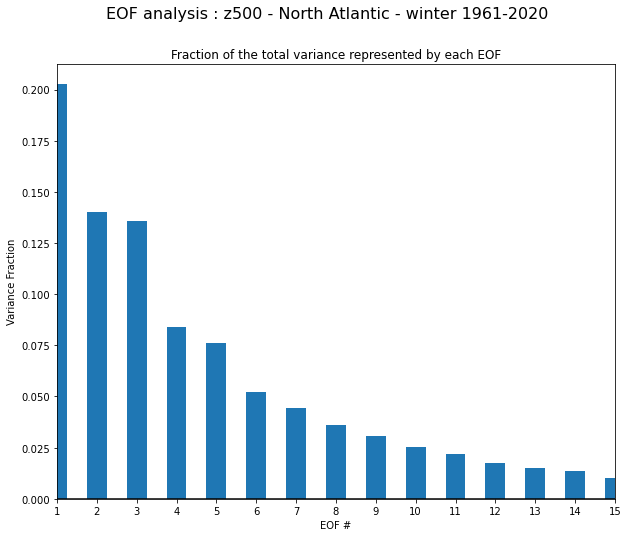

0.8270470752830407


In [13]:
varfrac = solver.varianceFraction()

fig = plt.figure(figsize=(10, 8))
fig.suptitle('EOF analysis : '+var_text+' - '+domain+' - '+season+ ' '+season1+'-'+season2, fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()

print(varfrac[0:10].sum())

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_varfrac'
fig.savefig(figname+'.png', bbox_inches='tight')

In [14]:
n=10
eofs = solver.eofsAsCovariance(neofs=n)
pcs = solver.pcs(npcs=n, pcscaling=0)

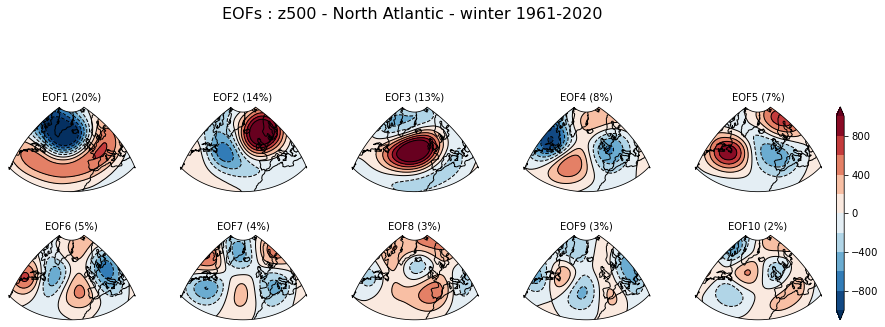

In [15]:
clevs = np.linspace(-1000, 1000, 11)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,6))
fig.suptitle('EOFs : '+var_text+' - '+domain+' - '+season+ ' '+season1+'-'+season2, fontsize=16)
axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, int(n/2)),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    ax.coastlines()
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.set_title('EOF'+str(i+1)+' ('+str(int(varfrac[i]*100))+'%)', fontsize=10, loc='center')
    cf = ax.contourf(lons, lats, eofs[i], clevs, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    c = ax.contour(lons, lats, eofs[i], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(cf)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_eofs'
fig.savefig(figname+'.png', bbox_inches='tight')

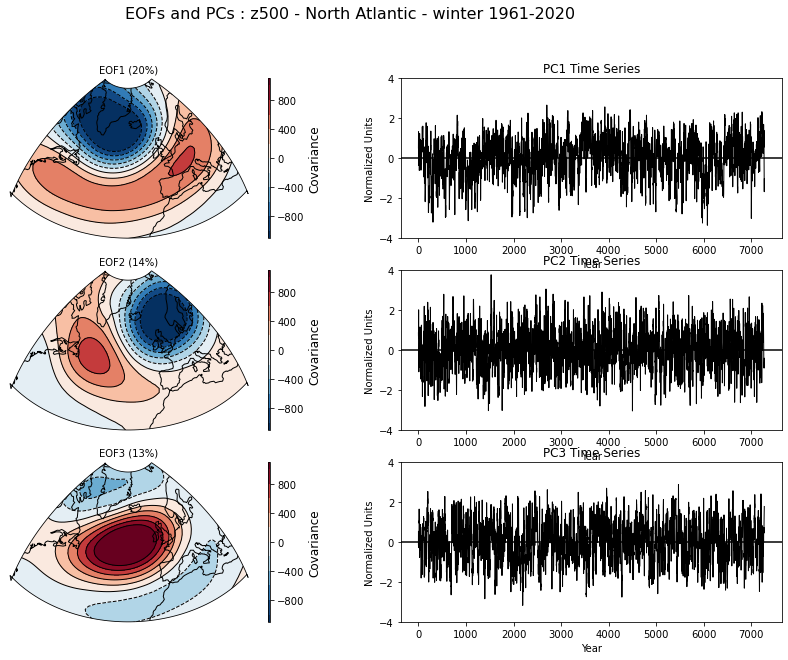

In [16]:
eof1=eofs[0]
eof2=eofs[1]*(-1)
eof3=eofs[2]

pc1=pcs[:,0]
pc2=pcs[:,1]*(-1)
pc3=pcs[:,2]

def plot_pc(ax):
    plt.xlabel('Year')
    plt.ylabel('Normalized Units')
    plt.axhline(0, color='k')
    ax.set_ylim(-4, 4)
    return ax

fig = plt.figure(figsize=(15, 10))

fig.suptitle('EOFs and PCs : '+var_text+' - '+domain+' - '+season+ ' '+season1+'-'+season2, fontsize=16)
ax = fig.add_subplot(3, 2, 1, projection=projection)
plt.title('EOF1 ('+str(int(varfrac[0]*100))+'%)', fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, eof1, levels=clevs, cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, eof1, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Covariance', fontsize=12)

ax = fig.add_subplot(3, 2, 2)
plot_pc(ax)
plt.title('PC1 Time Series')
plt.plot(pc1/pc1.std(), color='k', linewidth=1)

ax = fig.add_subplot(3, 2, 3, projection=projection)
plt.title('EOF2 ('+str(int(varfrac[1]*100))+'%)', fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, eof2, levels=clevs, cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, eof2, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Covariance', fontsize=12)

ax = fig.add_subplot(3, 2, 4)
plot_pc(ax)
plt.title('PC2 Time Series')
plt.plot(pc2/pc2.std(), color='k', linewidth=1)

ax = fig.add_subplot(3, 2, 5, projection=projection)
plt.title('EOF3 ('+str(int(varfrac[2]*100))+'%)', fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, eof3, levels=clevs, cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, eof3, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Covariance', fontsize=12)

ax = fig.add_subplot(3, 2, 6)
plot_pc(ax)
plt.title('PC3 Time Series')
plt.plot(pc3/pc3.std(), color='k', linewidth=1)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_eofs_pcs'
fig.savefig(figname+'.png', bbox_inches='tight')

In [17]:
def plot_phase_space2d(ax):
    plt.title('')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.axvline(0, color='k', linestyle='--')
    plt.axhline(0, color='k', linestyle='--')
    return ax

def plot_phase_space3d(ax):
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    return ax

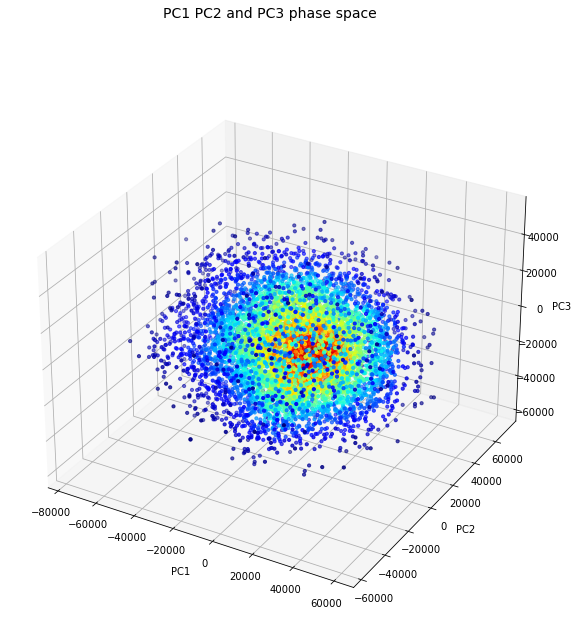

In [18]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('PC1 PC2 and PC3 phase space', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
plot_phase_space3d(ax)
xyz = np.vstack([pc1,pc2,pc3])
z = gaussian_kde(xyz)(xyz)
#ax.scatter(pc1,pc2,pc3, s=10, color = 'r')
ax.scatter(pc1, pc2, pc3, cmap='jet', c=z, s=10)
plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_pc123_density'
fig.savefig(figname+'.png', bbox_inches='tight')

# Etape 4 : classification en 4 classes = régimes (méthode k-means)

In [19]:
pcs = np.array([pc1,pc2,pc3,pcs[:,3],pcs[:,4],pcs[:,5],pcs[:,6],pcs[:,7],pcs[:,8],pcs[:,9]])
pcs=pcs.transpose()

# Number of clusters
kmeans = KMeans(n_clusters=4,n_init=100)
# Fitting the input data
kmeans = kmeans.fit(pcs)
# Getting the cluster labels
cluster = kmeans.predict(pcs)
# Centroid values
centroids = kmeans.cluster_centers_

print(cluster)
print(cluster.shape)
print(centroids.shape)

[0 0 0 ... 3 3 3]
(7275,)
(4, 10)


In [20]:
nc1=list(cluster[:]).count(0)
nc2=list(cluster[:]).count(1)
nc3=list(cluster[:]).count(2)
nc4=list(cluster[:]).count(3)

f1=int(nc1/cluster.shape[0]*100)
f2=int(nc2/cluster.shape[0]*100)
f3=int(nc3/cluster.shape[0]*100)
f4=int(nc4/cluster.shape[0]*100)

In [21]:
colors=[""]*len(cluster)
couleur=["blue","red","green","orange"]
for i in range(len(cluster)):
    colors[i]=couleur[cluster[i]]

label=couleur[0]+' : '+str(nc1)+' ('+str(f1)+'%)'+', '+couleur[1]+' : '+str(nc2)+' ('+str(f2)+'%)'+', '+couleur[2]+' : '+str(nc3)+' ('+str(f3)+'%)'+', '+couleur[3]+' : '+str(nc4)+' ('+str(f4)+'%)'
print(label)

blue : 2207 (30%), red : 1509 (20%), green : 1922 (26%), orange : 1637 (22%)


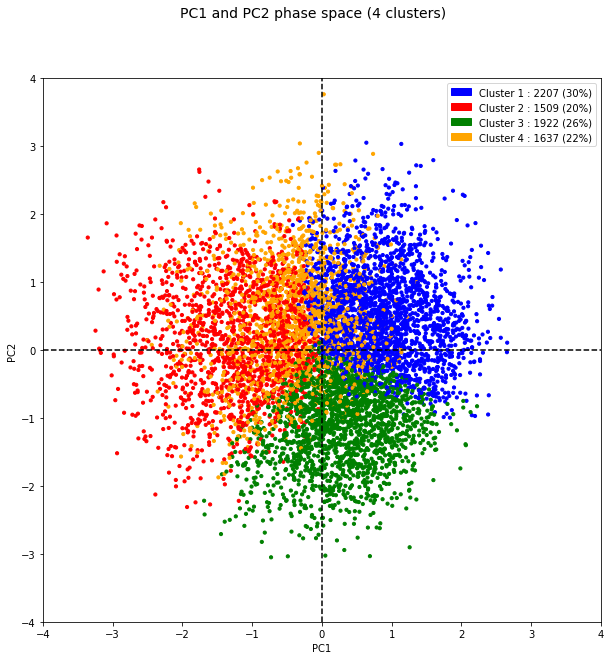

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('PC1 and PC2 phase space (4 clusters)', fontsize=14)
plot_phase_space2d(ax)
plt.scatter(pc1/pc1.std(), pc2/pc2.std(), c=colors, s=10, label=label)
plt.scatter(centroids[:, 0], centroids[:, 1], c=couleur, s=2000, alpha=1, marker='+');

patch1 = mpatches.Patch(color=couleur[0], label='Cluster 1 : '+str(nc1)+' ('+str(f1)+'%)')
patch2 = mpatches.Patch(color=couleur[1], label='Cluster 2 : '+str(nc2)+' ('+str(f2)+'%)')
patch3 = mpatches.Patch(color=couleur[2], label='Cluster 3 : '+str(nc3)+' ('+str(f3)+'%)')
patch4 = mpatches.Patch(color=couleur[3], label='Cluster 4 : '+str(nc4)+' ('+str(f4)+'%)')
all_handles = (patch1, patch2, patch3, patch4)
leg = ax.legend(handles=all_handles, loc='upper right')

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_pc12_clustering'
fig.savefig(figname+'.png', bbox_inches='tight')

# Etape 5 : obtention des régimes de temps

In [23]:
id_cluster1=np.any([cluster==0],axis=0)
id_cluster2=np.any([cluster==1],axis=0)
id_cluster3=np.any([cluster==2],axis=0)
id_cluster4=np.any([cluster==3],axis=0)

print(id_cluster1)
print(id_cluster2)
print(id_cluster3)
print(id_cluster4)

mean_c1 = var[id_cluster1,:,:].mean(axis=0)/var_div
mean_c2 = var[id_cluster2,:,:].mean(axis=0)/var_div
mean_c3 = var[id_cluster3,:,:].mean(axis=0)/var_div
mean_c4 = var[id_cluster4,:,:].mean(axis=0)/var_div

mean_c1_anom = var_anom[id_cluster1,:,:].mean(axis=0)/var_div
mean_c2_anom = var_anom[id_cluster2,:,:].mean(axis=0)/var_div
mean_c3_anom = var_anom[id_cluster3,:,:].mean(axis=0)/var_div
mean_c4_anom = var_anom[id_cluster4,:,:].mean(axis=0)/var_div

[ True  True  True ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ...  True  True  True]


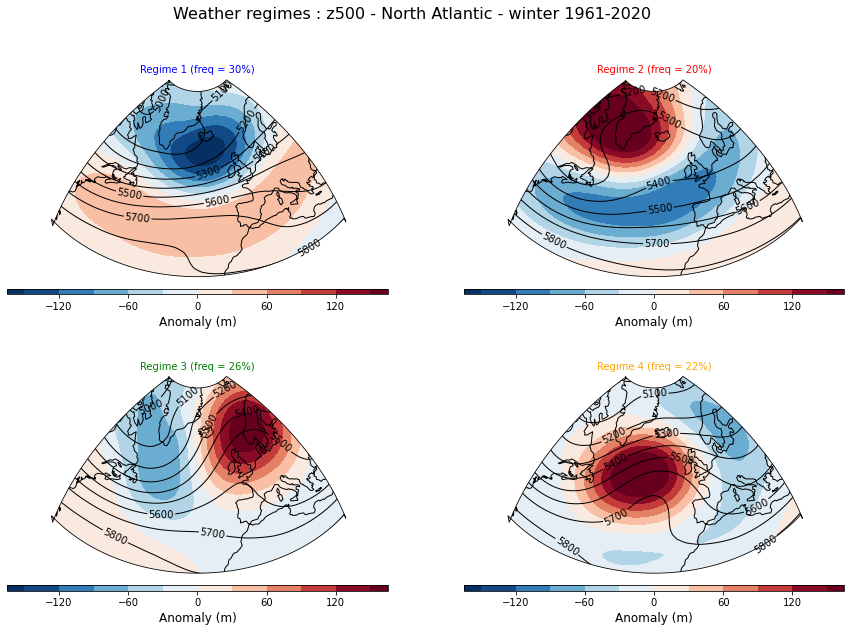

In [24]:
clevs = np.linspace(5000, 6000, 11)
clevs_anom = np.linspace(-150, 150, 11)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Weather regimes : '+var_text+' - '+domain+' - '+season+ ' '+season1+'-'+season2, fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=projection)
plt.title('Regime 1 (freq = '+str(f1)+'%)', fontsize=10, loc='center', color=couleur[0])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, mean_c1_anom, levels=clevs_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, mean_c1, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ('+units+')', fontsize=12)

ax = fig.add_subplot(2, 2, 2, projection=projection)
plt.title('Regime 2 (freq = '+str(f2)+'%)', fontsize=10, loc='center', color=couleur[1])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, mean_c2_anom, levels=clevs_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, mean_c2, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ('+units+')', fontsize=12)

ax = fig.add_subplot(2, 2, 3, projection=projection)
plt.title('Regime 3 (freq = '+str(f3)+'%)', fontsize=10, loc='center', color=couleur[2])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, mean_c3_anom, levels=clevs_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, mean_c3, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ('+units+')', fontsize=12)

ax = fig.add_subplot(2, 2, 4, projection=projection)
plt.title('Regime 4 (freq = '+str(f4)+'%)', fontsize=10, loc='center', color=couleur[3])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lons, lats, mean_c4_anom, levels=clevs_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
c = ax.contour(lons, lats, mean_c4, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ('+units+')', fontsize=12)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_'+'regimes'
fig.savefig(figname+'.png', bbox_inches='tight')

In [25]:
r1 = 'AR'#'r1'
r2 = 'NAO-'#'r2'
r3 = 'BL'#'r3'
r4 = 'NAO+'#'r4'

regime=[r1, r2, r3, r4]

# Etape 6 : temps sensible associé aux régimes de temps

In [26]:
d1='1979-12-01T09'
d2='2018-03-31T09'

# Date index from startday to endday
d = pd.date_range(d1, d2, freq='D')
mm=np.any([d.month==12,d.month==1,d.month==2,d.month==3],axis=0)
dd2=d[mm]

# data_t    = xr.open_dataset(dir_data+'t2m_eur_19790101_20191231.nc').sel(time=slice(d1,d2))
# data_t    = data_t.sel(time=dd2)

# data_tp    = xr.open_dataset(dir_data+'tp_eur_19790101_20191231.nc').sel(time=slice(d1,d2))
# data_tp    = data_tp.sel(time=dd2)

data_wind10 = xr.open_dataset(dir_data+'wind10_eur_19790101_20191231.nc').sel(time=dd2)
data_u10 = xr.open_dataset(dir_data+'u10_eur_19790101_20191231.nc').sel(time=dd2)
data_v10 = xr.open_dataset(dir_data+'v10_eur_19790101_20191231.nc').sel(time=dd2)

lat_t  = data_u10.latitude.values
lon_t  = data_u10.longitude.values
time_t  = data_u10.time.values

In [27]:
# print(' ----- Computing daily anomalies of T2m ----- ')
# data_t_anom = data_t.groupby('time.dayofyear') - data_t.groupby('time.dayofyear').mean('time')
# print(' ----- Computing daily anomalies of precipitation ----- ')
# data_tp_anom = data_tp.groupby('time.dayofyear') - data_tp.groupby('time.dayofyear').mean('time')
print(' ----- Computing daily anomalies of wind ----- ')
data_wind10_anom = data_wind10.groupby('time.dayofyear') - data_wind10.groupby('time.dayofyear').mean('time')

# t2m_anom=data_t_anom['t2m']
# tp_anom=data_tp_anom['tp']*1000
wind10_anom = data_wind10_anom['ws']

 ----- Computing daily anomalies of wind ----- 


In [47]:
len(cluster)

7275

In [29]:
dd1='1979-12-01T18'
dd2='2018-03-31T18'

index_y=np.all([dates2>=dd1, dates2<=dd2], axis=0)
cluster_t=cluster[index_y]

id_cluster1_t=np.any([cluster_t==0],axis=0)
id_cluster2_t=np.any([cluster_t==1],axis=0)
id_cluster3_t=np.any([cluster_t==2],axis=0)
id_cluster4_t=np.any([cluster_t==3],axis=0)

# mean_c1_anom_t = t2m_anom[id_cluster1_t,:,:].mean(axis=0)
# mean_c2_anom_t = t2m_anom[id_cluster2_t,:,:].mean(axis=0)
# mean_c3_anom_t = t2m_anom[id_cluster3_t,:,:].mean(axis=0)
# mean_c4_anom_t = t2m_anom[id_cluster4_t,:,:].mean(axis=0)

# mean_c1_anom_tp = tp_anom[id_cluster1_t,:,:].mean(axis=0)
# mean_c2_anom_tp = tp_anom[id_cluster2_t,:,:].mean(axis=0)
# mean_c3_anom_tp = tp_anom[id_cluster3_t,:,:].mean(axis=0)
# mean_c4_anom_tp = tp_anom[id_cluster4_t,:,:].mean(axis=0)

mean_c1_anom_wind10 = wind10_anom[id_cluster1_t,:,:].mean(axis=0)
mean_c2_anom_wind10 = wind10_anom[id_cluster2_t,:,:].mean(axis=0)
mean_c3_anom_wind10 = wind10_anom[id_cluster3_t,:,:].mean(axis=0)
mean_c4_anom_wind10 = wind10_anom[id_cluster4_t,:,:].mean(axis=0)

mean_c1_u10 = np.array(data_u10['u10'][id_cluster1_t,:,:].mean(axis=0))
mean_c2_u10 = np.array(data_u10['u10'][id_cluster2_t,:,:].mean(axis=0))
mean_c3_u10 = np.array(data_u10['u10'][id_cluster3_t,:,:].mean(axis=0))
mean_c4_u10 = np.array(data_u10['u10'][id_cluster4_t,:,:].mean(axis=0))

mean_c1_v10 = np.array(data_v10['v10'][id_cluster1_t,:,:].mean(axis=0))
mean_c2_v10 = np.array(data_v10['v10'][id_cluster2_t,:,:].mean(axis=0))
mean_c3_v10 = np.array(data_v10['v10'][id_cluster3_t,:,:].mean(axis=0))
mean_c4_v10 = np.array(data_v10['v10'][id_cluster4_t,:,:].mean(axis=0))

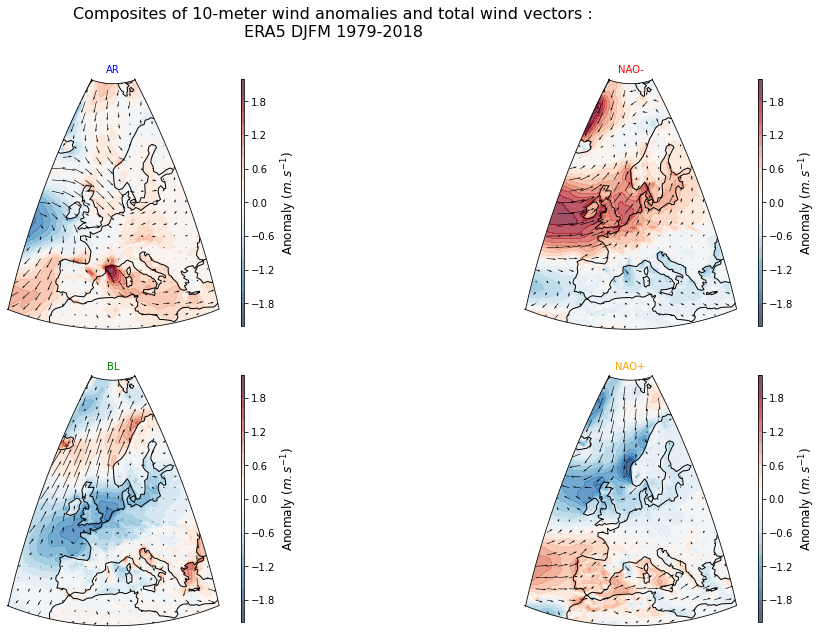

In [28]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 30, 30, 80)]

levs_wind10_anom = np.linspace(-2, 2, 21)

fig = plt.figure(figsize=(17, 10))
fig.suptitle('Composites of 10-meter wind anomalies and total wind vectors :\nERA5 DJFM 1979-2018', fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=projection2)
plt.title(regime[0], fontsize=10, loc='center', color=couleur[0])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c1_u10, mean_c1_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c1_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 2, 2, projection=projection2)
plt.title(regime[1], fontsize=10, loc='center', color=couleur[1])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c2_u10, mean_c2_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c2_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 2, 3, projection=projection2)
plt.title(regime[2], fontsize=10, loc='center', color=couleur[2])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c3_u10, mean_c3_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c3_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 2, 4, projection=projection2)
plt.title(regime[3], fontsize=10, loc='center', color=couleur[3])
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c4_u10, mean_c4_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c4_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_v_composite_DJFM'
fig.savefig(figname+'.jpeg', bbox_inches='tight')

In [29]:
# projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
# bounds = [(-20, 30, 30, 80)]

# levs_t_anom = np.linspace(-5, 5, 21)

# fig = plt.figure(figsize=(15, 10))
# fig.suptitle('Composites of 2-meter temperature anomalies : ERA5 DJFM 1979-2018', fontsize=16)

# ax = fig.add_subplot(2, 2, 1, projection=projection2)
# plt.title(regime[0], fontsize=10, loc='center', color=couleur[0])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c1_anom_t, levels=levs_t_anom, 
#                  cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (°C)', fontsize=12)

# ax = fig.add_subplot(2, 2, 2, projection=projection2)
# plt.title(regime[1], fontsize=10, loc='center', color=couleur[1])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c2_anom_t, levels=levs_t_anom, 
#                  cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (°C)', fontsize=12)

# ax = fig.add_subplot(2, 2, 3, projection=projection2)
# plt.title(regime[2], fontsize=10, loc='center', color=couleur[2])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c3_anom_t, levels=levs_t_anom, 
#                  cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (°C)', fontsize=12)

# ax = fig.add_subplot(2, 2, 4, projection=projection2)
# plt.title(regime[3], fontsize=10, loc='center', color=couleur[3])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c4_anom_t, levels=levs_t_anom, 
#                  cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (°C)', fontsize=12)

# plt.show()

# figname=dir_figs+varname+'_'+domain_name+'_t2m_composite_DJFM'
# fig.savefig(figname+'.png', bbox_inches='tight')

In [30]:
# cmap3='BrBG'

# levs_tp_anom = np.linspace(-1, 1, 21)

# fig = plt.figure(figsize=(15, 10))
# fig.suptitle('Composites of precipitation anomalies : ERA5 1979-2018', fontsize=16)

# ax = fig.add_subplot(2, 2, 1, projection=projection2)
# plt.title(regime[0], fontsize=10, loc='center', color=couleur[0])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c1_anom_tp, levels=levs_tp_anom, 
#                  cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (mm/day)', fontsize=12)

# ax = fig.add_subplot(2, 2, 2, projection=projection2)
# plt.title(regime[1], fontsize=10, loc='center', color=couleur[1])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c2_anom_tp, levels=levs_tp_anom, 
#                  cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (mm/day)', fontsize=12)

# ax = fig.add_subplot(2, 2, 3, projection=projection2)
# plt.title(regime[2], fontsize=10, loc='center', color=couleur[2])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c3_anom_tp, levels=levs_tp_anom, 
#                  cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (mm/day)', fontsize=12)

# ax = fig.add_subplot(2, 2, 4, projection=projection2)
# plt.title(regime[3], fontsize=10, loc='center', color=couleur[3])
# ax.coastlines()
# ax.set_extent(*bounds, crs=ccrs.PlateCarree())
# boundary_path = make_boundary_path(lon_t, lat_t)
# ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
# cf = ax.contourf(lon_t, lat_t, mean_c4_anom_tp, levels=levs_tp_anom, 
#                  cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
# ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
# cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
# cb.set_label('Anomaly (mm/day)', fontsize=12)

# plt.show()

# figname=dir_figs+varname+'_'+domain_name+'_precip_composite_DJFM'
# fig.savefig(figname+'.png', bbox_inches='tight')

# Etape 7 : étude des occurrences saisonnières des régimes

In [31]:
# Find indexes for end of season
time_str = [x for x in range(len(dates2))]
date_str = [x for x in range(len(dates2))]
for i in range(len(dates2)):
    time_str[i] = str(dates2[i])
    date_str[i] = time_str[i][5:10]

if season_name == 'winter':
    index_end = [i for i, value in enumerate(date_str) if value == '03-31']

if season_name == 'summer':
    index_end = [i for i, value in enumerate(date_str) if value == '08-31']
    
print(index_end)
print(len(index_end))

seasons= [x for x in range(int(season1),int(season2)+1)]
cl1_count=np.zeros(len(index_end))
cl2_count=np.zeros(len(index_end))
cl3_count=np.zeros(len(index_end))
cl4_count=np.zeros(len(index_end))

# Cluster1
cl1_count[0]=list(cluster[0:index_end[0]+1]).count(0)
for i in range(1,len(index_end)):
 cl1_count[i]=list(cluster[index_end[i-1]+1:index_end[i]+1]).count(0)
 
# Cluster2
cl2_count[0]=list(cluster[0:index_end[0]+1]).count(1)
for i in range(1,len(index_end)):
 cl2_count[i]=list(cluster[index_end[i-1]+1:index_end[i]+1]).count(1)

# Cluster3
cl3_count[0]=list(cluster[0:index_end[0]+1]).count(2)
for i in range(1,len(index_end)):
 cl3_count[i]=list(cluster[index_end[i-1]+1:index_end[i]+1]).count(2)

# Cluster4
cl4_count[0]=list(cluster[0:index_end[0]+1]).count(3)
for i in range(1,len(index_end)):
 cl4_count[i]=list(cluster[index_end[i-1]+1:index_end[i]+1]).count(3)

print(seasons)
print(cl1_count)

[120, 241, 362, 484, 605, 726, 847, 969, 1090, 1211, 1332, 1454, 1575, 1696, 1817, 1939, 2060, 2181, 2302, 2424, 2545, 2666, 2787, 2909, 3030, 3151, 3272, 3394, 3515, 3636, 3757, 3879, 4000, 4121, 4242, 4364, 4485, 4606, 4727, 4849, 4970, 5091, 5212, 5334, 5455, 5576, 5697, 5819, 5940, 6061, 6182, 6304, 6425, 6546, 6667, 6789, 6910, 7031, 7152, 7274]
60
[1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
[30. 17. 23. 18. 34. 25. 45. 46. 30. 49. 26. 20. 31. 28. 27. 51.  7. 18.
 20. 18. 43. 19. 48. 35. 14. 19. 29. 29. 22.  6. 27. 35. 30. 16. 25. 27.
 17. 32. 37. 59. 10. 11. 16. 43. 45. 28. 17. 18. 30.  6. 22. 46. 22. 13.
 43. 24. 27. 35. 29. 13.]


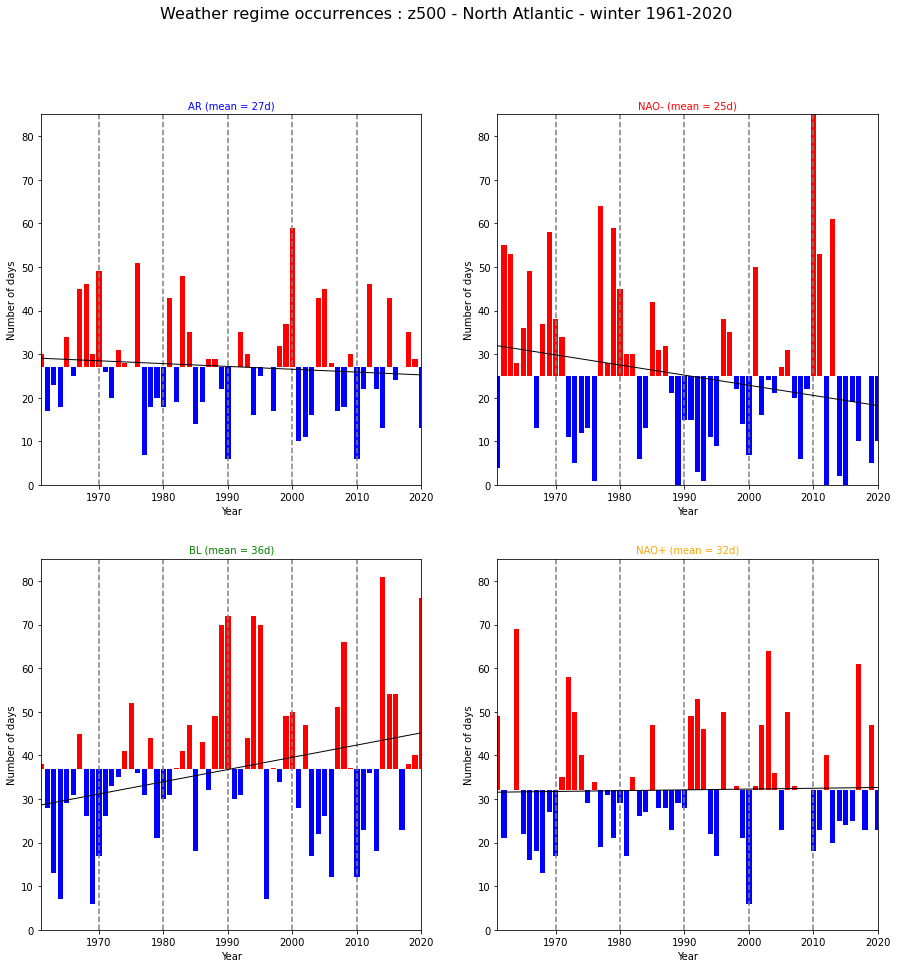

In [32]:
# calculate trends
X = np.reshape(seasons, (len(seasons), 1))

y = cl1_count
model = LinearRegression()
model.fit(X, cl1_count)
trend_cl1 = model.predict(X)

y = cl2_count
model = LinearRegression()
model.fit(X, cl2_count)
trend_cl2 = model.predict(X)

y = cl3_count
model = LinearRegression()
model.fit(X, cl3_count)
trend_cl3 = model.predict(X)

y = cl4_count
model = LinearRegression()
model.fit(X, cl4_count)
trend_cl4 = model.predict(X)

def plot_regimes_occ(ax):
 plt.xlabel('Year')
 plt.ylabel('Number of days')
 plt.xlim(int(season1), int(season2))
 plt.ylim(0, 85)
 plt.axvline(1960, color='grey', linestyle='--')
 plt.axvline(1970, color='grey', linestyle='--')
 plt.axvline(1980, color='grey', linestyle='--')
 plt.axvline(1990, color='grey', linestyle='--')
 plt.axvline(2000, color='grey', linestyle='--')
 plt.axvline(2010, color='grey', linestyle='--')
 return ax

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Weather regime occurrences : '
             +var_text+' - '+domain+' - '+season+ ' '+season1+'-'+season2, fontsize=16)
ax = fig.add_subplot(2, 2, 1)
plt.title(regime[0]+' (mean = '+str(int(cl1_count.mean()))+'d)', fontsize=10, loc='center', color=couleur[0])
plot_regimes_occ(ax)
colormat=np.where(cl1_count>cl1_count.mean(), 'red','blue')
plt.bar(seasons,cl1_count-cl1_count.mean(), bottom=cl1_count.mean(), color=colormat, linewidth=1)
plt.plot(seasons,trend_cl1, color='k', linewidth=1)

ax = fig.add_subplot(2, 2, 2)
plt.title(regime[1]+' (mean = '+str(int(cl2_count.mean()))+'d)', fontsize=10, loc='center', color=couleur[1])
plot_regimes_occ(ax)
colormat=np.where(cl2_count>cl2_count.mean(), 'red','blue')
plt.bar(seasons,cl2_count-cl2_count.mean(), bottom=cl2_count.mean(), color=colormat, linewidth=1)
plt.plot(seasons,trend_cl2, color='k', linewidth=1)

ax = fig.add_subplot(2, 2, 3)
plt.title(regime[2]+' (mean = '+str(int(cl3_count.mean()))+'d)', fontsize=10, loc='center', color=couleur[2])
plot_regimes_occ(ax)
colormat=np.where(cl3_count>cl3_count.mean(), 'red','blue')
plt.bar(seasons,cl3_count-cl3_count.mean(), bottom=cl3_count.mean(), color=colormat, linewidth=1)
plt.plot(seasons,trend_cl3, color='k', linewidth=1)

ax = fig.add_subplot(2, 2, 4)
plt.title(regime[3]+' (mean = '+str(int(cl4_count.mean()))+'d)', fontsize=10, loc='center', color=couleur[3])
plot_regimes_occ(ax)
colormat=np.where(cl4_count>cl4_count.mean(), 'red','blue')
plt.bar(seasons,cl4_count-cl4_count.mean(), bottom=cl4_count.mean(), color=colormat, linewidth=1)
plt.plot(seasons,trend_cl4, color='k', linewidth=1)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_regimes_occurrence'
fig.savefig(figname+'.png', bbox_inches='tight')

In [33]:
print("Classement "+regime[0])
print(np.sort(cl1_count))
rank=[]
for i in np.argsort(cl1_count):
    rank.append(seasons[i]) 
print(rank)
print("****************************************************")

print("Classement "+regime[1])
print(np.sort(cl2_count))
rank=[]
for i in np.argsort(cl2_count):
    rank.append(seasons[i]) 
print(rank)
print("****************************************************")

print("Classement "+regime[2])
print(np.sort(cl3_count))
rank=[]
for i in np.argsort(cl3_count):
    rank.append(seasons[i]) 
print(rank)
print("****************************************************")

print("Classement "+regime[3])
print(np.sort(cl4_count))
rank=[]
for i in np.argsort(cl4_count):
    rank.append(seasons[i]) 
print(rank)
print("****************************************************")

Classement AR
[ 6.  6.  7. 10. 11. 13. 13. 14. 16. 16. 17. 17. 17. 18. 18. 18. 18. 19.
 19. 20. 20. 22. 22. 22. 23. 24. 25. 25. 26. 27. 27. 27. 27. 28. 28. 29.
 29. 29. 30. 30. 30. 30. 31. 32. 34. 35. 35. 35. 37. 43. 43. 43. 45. 45.
 46. 46. 48. 49. 51. 59.]
[1990, 2010, 1977, 2001, 2002, 2014, 2020, 1985, 1994, 2003, 1997, 2007, 1962, 2008, 1980, 1978, 1964, 1982, 1986, 1979, 1972, 2013, 1989, 2011, 1963, 2016, 1966, 1995, 1971, 1975, 1991, 1996, 2017, 1974, 2006, 1987, 2019, 1988, 2009, 1961, 1993, 1969, 1973, 1998, 1965, 1992, 1984, 2018, 1999, 2004, 1981, 2015, 2005, 1967, 1968, 2012, 1983, 1970, 1976, 2000]
****************************************************
Classement NAO-
[ 0.  0.  0.  1.  1.  2.  3.  4.  5.  5.  6.  6.  7.  9. 10. 10. 11. 11.
 12. 13. 13. 13. 14. 15. 15. 16. 19. 20. 21. 21. 22. 22. 24. 25. 27. 28.
 28. 30. 30. 31. 31. 32. 34. 35. 36. 37. 38. 38. 42. 45. 49. 50. 53. 53.
 55. 58. 59. 61. 64. 85.]
[2015, 2012, 1989, 1993, 1976, 2014, 1992, 1961, 2019, 1973, 2008,

# Etape 8 : retour sur une saison particulière

In [34]:
if season_name == 'winter':
    choix=input('hiver ? ')
    leap_year=calendar.isleap(int(choix)+1)
    if var_text=='Z500':
        date1=choix+'-12-01T18'
    if var_text=='MSLP':
        date1=choix+'-12-01T09'
    idx_date1=dates2.get_loc(date1, method ='ffill')
    if leap_year:
        print('Année bisextile')
        idx_date2=idx_date1+122
    else:
        idx_date2=idx_date1+121
    
if season_name == 'summer':
    choix=input('été ? ')
    if var_text=='Z500':
        date1=choix+'-06-01T18'
    if var_text=='MSLP':
        date1=choix+'-06-01T09'
    idx_date2=idx_date1+121

hiver ? 


ValueError: invalid literal for int() with base 10: ''

In [ ]:
pc_dates=dates2[idx_date1:idx_date2]
print(pc_dates[0])
print(pc_dates[-1])
print(pc_dates.shape)

date2=pc_dates[-1]
date2=str(pc_dates[-1])
date2=date2[0:10]

time_str = [x for x in range(len(pc_dates))]
date_str = [x for x in range(len(pc_dates))]
date_str_title = [x for x in range(len(pc_dates))]

for i in range(len(pc_dates)):
    time_str[i] = str(pc_dates[i])
    date_str_title[i] = time_str[i][0:10]	
    date_str[i] = time_str[i][5:10]
    
leap_year=calendar.isleap(int(time_str[-1][0:4]))
if leap_year:
    print('Année bisextile')

In [ ]:
data_month_anom    = data_anom.sel(time=slice(date1,date2))
z_anom=data_month_anom[varname]/var_div
print(z_anom.shape)

time  = data_month_anom.time.values
lat  = data_month_anom.lat.values
lon  = data_month_anom.lon.values

In [ ]:
if varname=='zg500':
    plt_title2 = 'Geopotential height anomaly ('+units+') at 500 hPa : '+ str(date1)+'-'+str(date2)

if varname=='slp':
    plt_title2 = 'Mean Sea Level Pressure anomaly ('+units+') : '+ str(date1)+'-'+str(date2)

#
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(17,10))
fig.suptitle(plt_title2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 6),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    reg=cluster[idx_date1+i] # régime
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_title(date_str_title[i]+' '+regime[reg], fontsize=10, color=colors[idx_date1+i])
    p1 = ax.contourf(lon, lat, z_anom[i,:,:], levels2, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    p2 = ax.contour(lon, lat, z_anom[i,:,:], levels2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+varname+'_anom_'+domain_name+'_'+season_name+'_cluster_'+str(date1)+'-'+str(date2)+'_1'
fig.savefig(figname+'.png', bbox_inches='tight')

#
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(17,10))
fig.suptitle(plt_title2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 6),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    reg=cluster[idx_date1+30+i] # régime
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_title(date_str_title[i+30]+' '+regime[reg], fontsize=10, color=colors[idx_date1+i+30])
    p1 = ax.contourf(lon, lat, z_anom[i+30,:,:], levels2, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    p2 = ax.contour(lon, lat, z_anom[i+30,:,:], levels2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+varname+'_anom_'+domain_name+'_'+season_name+'_cluster_'+str(date1)+'-'+str(date2)+'_2'
fig.savefig(figname+'.png', bbox_inches='tight')

#
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(17,10))
fig.suptitle(plt_title2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 6),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    reg=cluster[idx_date1+60+i] # régime
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_title(date_str_title[i+60]+' '+regime[reg], fontsize=10, color=colors[idx_date1+i+60])
    p1 = ax.contourf(lon, lat, z_anom[i+60,:,:], levels2, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    p2 = ax.contour(lon, lat, z_anom[i+60,:,:], levels2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+varname+'_anom_'+domain_name+'_'+season_name+'_cluster_'+str(date1)+'-'+str(date2)+'_3'
fig.savefig(figname+'.png', bbox_inches='tight')

#
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(17,10))
fig.suptitle(plt_title2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 6),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    reg=cluster[idx_date1+90+i] # régime
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_title(date_str_title[i+90]+' '+regime[reg], fontsize=10, color=colors[idx_date1+i+90])
    p1 = ax.contourf(lon, lat, z_anom[i+90,:,:], levels2, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    p2 = ax.contour(lon, lat, z_anom[i+90,:,:], levels2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+varname+'_anom_'+domain_name+'_'+season_name+'_cluster_'+str(date1)+'-'+str(date2)+'_4'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
for i in range(len(time)):
    #print(date_str[i])
    reg=cluster[idx_date1+i]
    if reg==0:
            composite  = mean_c1_anom
    if reg==1:
            composite  = mean_c2_anom
    if reg==2:
            composite  = mean_c3_anom
    if reg==3:
            composite  = mean_c4_anom
    fig = plt.figure(figsize=(15., 5.))
    fig.suptitle(plt_title2, fontsize=16)
    
    ax = fig.add_subplot(1,2,1, projection=projection)
    ax.set_title(date_str_title[i]+' '+regime[reg], fontsize=10, color=colors[idx_date1+i])
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    p1 = ax.contourf(lon, lat, z_anom[i,:,:], levels2, transform=ccrs.PlateCarree(), cmap=cmap2, extend='both')
    p2 = ax.contour(lon, lat, z_anom[i,:,:], levels2, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    cb = fig.colorbar(p1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05, extendrect='True')
    cb.set_label('Anomaly ('+units+')', fontsize=12)
    
    ax = fig.add_subplot(1,2,2, projection=projection)
    plt.title(regime[reg]+' composite', fontsize=10, loc='center', color=colors[idx_date1+i])
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, composite, levels=clevs_anom, 
                     cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
    c = ax.contour(lons, lats, mean_c4, levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05, extendrect='True')
    cb.set_label('Anomaly ('+units+')', fontsize=12)

    figname=dir_anim+varname+'_anom_cluster'+domain_name+'_'+season_name+'_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')
    plt.close()
print('png files are in the animation folder, ready to make the animation')

In [ ]:
gif_filepath = dir_anim+varname+'_anom_cluster_'+domain_name+'_'+season_name+'_'+str(date1)+'-'+str(date2)+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [ ]:
nc1s=list(cluster[idx_date1:idx_date2]).count(0)
nc2s=list(cluster[idx_date1:idx_date2]).count(1)
nc3s=list(cluster[idx_date1:idx_date2]).count(2)
nc4s=list(cluster[idx_date1:idx_date2]).count(3)

f1s=int(nc1s/cluster[idx_date1:idx_date2].shape[0]*100)
f2s=int(nc2s/cluster[idx_date1:idx_date2].shape[0]*100)
f3s=int(nc3s/cluster[idx_date1:idx_date2].shape[0]*100)
f4s=int(nc4s/cluster[idx_date1:idx_date2].shape[0]*100)

In [ ]:
def plot_regimes_leg(ax):
    patch1 = mpatches.Patch(color=couleur[0], label=regime[0]+' : '+str(nc1s)+' ('+str(f1s)+'%)')
    patch2 = mpatches.Patch(color=couleur[1], label=regime[1]+' : '+str(nc2s)+' ('+str(f2s)+'%)')
    patch3 = mpatches.Patch(color=couleur[2], label=regime[2]+' : '+str(nc3s)+' ('+str(f3s)+'%)')
    patch4 = mpatches.Patch(color=couleur[3], label=regime[3]+' : '+str(nc4s)+' ('+str(f4s)+'%)')
    all_handles = (patch1, patch2, patch3, patch4)
    leg = ax.legend(handles=all_handles, loc='lower right')
    return ax

In [ ]:
fig = plt.figure(figsize=(15, 2))
fig.suptitle('Weather regimes : '+date_str_title[0]+' to '+date_str_title[-1], fontsize=14)

ax = fig.add_subplot(1, 1, 1)

# create a collection with a rectangle for each day
col = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(len(pc_dates))])

#data = cluster[idx_date1:idx_date2]
#col.set_array(data)
col.set_color(colors[idx_date1:idx_date2])
ax.add_collection(col)

if season_name == 'winter':
    labels = ("Dec", "Jan", "Feb", "Mar")
    positions = (0, 31, 31+28, 31+28+31)
    if leap_year:
        positions = (0, 31, 31+29, 31+29+31)

if season_name == 'summer':
    positions = (0, 30, 30+31, 30+31+31)
    labels = ("Jun", "Jul", "Aug", "Sep")

plt.xticks(positions, labels)
ax.set_ylim(0, 1)
ax.set_xlim(0, len(pc_dates))
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.axvline(x=positions[1], c='black')
plt.axvline(x=positions[2], c='black')
plt.axvline(x=positions[3], c='black')

plot_regimes_leg(ax)

fig.savefig(dir_figs+varname+'_'+domain_name+'_'+season_name+
            '_regimes-stripes_'+date_str_title[0]+'-'+date_str_title[-1]+'.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('PC1 and PC2 phase space : '+date_str_title[0]+' to '+date_str_title[-1], fontsize=14)

ax = fig.add_subplot(1, 1, 1)
plot_phase_space2d(ax)
ax.scatter(pcs[idx_date1:idx_date2,0], pcs[idx_date1:idx_date2,1], c=colors[idx_date1:idx_date2], s=10)
ax.scatter(centroids[:, 0], centroids[:, 1], c=couleur, s=2000, alpha=1, marker='+')

for i,type in enumerate(date_str):
    x = pc1[idx_date1+i]
    y = pc2[idx_date1+i]
    plt.text(x, y, type, fontsize=6)

plot_regimes_leg(ax)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_pc12_'+date_str_title[0]+'-'+date_str_title[-1]
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('PC phase space : '+date_str_title[0]+' to '+date_str_title[-1], fontsize=14)

ax = fig.add_subplot(111, projection='3d')
plot_phase_space3d(ax)
ax.scatter(pcs[idx_date1:idx_date2,0], pcs[idx_date1:idx_date2,1], pcs[idx_date1:idx_date2,2],
           c=colors[idx_date1:idx_date2], s=10)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c=couleur, s=200, alpha=1, marker='+')

plot_regimes_leg(ax)

plt.show()

figname=dir_figs+varname+'_'+domain_name+'_'+season_name+'_pc123_'+date_str_title[0]+'-'+date_str_title[-1]
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
# loop for each day	
for i in range(len(pc_dates)):
 #print(date_str[i])
 fig = plt.figure(figsize=(10, 10))
 fig.suptitle('PC1 and PC2 phase space : '+date_str_title[0]+' to '+date_str_title[-1], fontsize=14)
 ax = fig.add_subplot(1, 1, 1)
 plot_phase_space2d(ax)
 ax.scatter(pcs[idx_date1:idx_date1+i+1,0], pcs[idx_date1:idx_date1+i+1,1], 
            c=colors[idx_date1:idx_date1+i+1], s=10)
 ax.scatter(centroids[:, 0], centroids[:, 1], c=couleur, s=2000, alpha=1, marker='+')
 x = pc1[idx_date1+i]
 y = pc2[idx_date1+i]
 plt.text(x, y, date_str[i], fontsize=10)
 plot_regimes_leg(ax)
 figname=dir_anim+varname+'_'+domain_name+'_'+season_name+'_PC_2d_phase_space_4clusters_'+date_str_title[i]
 fig.savefig(figname+'.png')
 plt.close()

In [ ]:
def make_animation2():
    nbimages=len(pc_dates)
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 1000 ms
    standard_duration = 1000 #show all other frames for 1000 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir(dir_anim)
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../")
    return Image

In [ ]:
gif_filepath = dir_anim+varname+'_'+domain_name+'_'+season_name+'_PC_2d_phase_space_4clusters_'+date_str_title[0]+'-'+date_str_title[-1]+'.gif'
make_animation2()
IPdisplay.Image(url=gif_filepath)

In [ ]:
import scipy.spatial.distance as sdist
dist=sdist.cdist(pcs, centroids)
dist_c1=dist[:,0]
dist_c2=dist[:,1]
dist_c3=dist[:,2]
dist_c4=dist[:,3]

def plot_dist(ax):
    plt.ylim(0, 5)
    plt.axhline(0, color='k')
    plt.xlim(xmin=datetime.datetime(int(str(pc_dates[0])[0:4]), int(str(pc_dates[0])[5:7]),
                                    int(str(pc_dates[0])[8:10])),
             xmax=datetime.datetime(int(str(pc_dates[-1])[0:4]), int(str(pc_dates[-1])[5:7]),
                                    int(str(pc_dates[-1])[8:10])))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    return ax

d1=dist_c1[idx_date1:idx_date2] # distance au régime 1
d2=dist_c2[idx_date1:idx_date2] # distance au régime 2
d3=dist_c3[idx_date1:idx_date2] # distance au régime 3
d4=dist_c4[idx_date1:idx_date2] # distance au régime 4
print(d2.shape)

fig=plt.figure(figsize=(20, 7))
fig.suptitle('Regime distance from centroid', fontsize=16)

ax = fig.add_subplot(4, 1, 1)
plot_dist(ax)
plt.scatter(pc_dates, d1, color='blue', s=10000/(d1**6), label='Distance '+regime[0])
plt.legend()

ax = fig.add_subplot(4, 1, 2)
plot_dist(ax)
plt.scatter(pc_dates, d2, color='red', s=10000/(d2**6), label='Distance '+regime[1])
plt.legend()

ax = fig.add_subplot(4, 1, 3)
plot_dist(ax)
plt.scatter(pc_dates, d3, color='green', s=10000/(d3**6), label='Distance '+regime[2])
plt.legend()

ax = fig.add_subplot(4, 1, 4)
plot_dist(ax)
plt.scatter(pc_dates, d4, color='orange', s=10000/(d4**6), label='Distance '+regime[3])
plt.axhline(0, color='k')
plt.legend()

plt.show()

fig.savefig(dir_figs+varname+'_'+domain_name+'_'+season_name+
            '_regimes-distances_'+date_str_title[0]+'-'+date_str_title[-1]+'.png', bbox_inches='tight')

# Séquences record de régime

In [ ]:
print(cluster)

#with np.printoptions(threshold=np.inf):
#    print(cluster)
    
#for i in range(len(cluster)):
#    print(regime[cluster[i]])

print(dates2)

In [ ]:
from itertools import groupby
count_dups = [sum(1 for _ in group) for _, group in groupby(cluster)]

#print(count_dups)

print("TOP 20")
for i in range(1,21):
    print("N°"+str(i))
    print("Nombre de jours consécutifs : ", np.sort(count_dups)[-i])
    idmax=sum(count_dups[0:np.argsort(count_dups)[-i]]) # indice du maximum d'occurence
    print("Régime concerné : ", regime[cluster[idmax]])
    print("Date de début de la séquence : ", dates2[idmax])
    print("Date de fin de la séquence : ", dates2[idmax+np.sort(count_dups)[-i]-1])
    print("****************************************************")